# ECE 271A HW \#3 The Cheetah Problem (Continued)

In [1]:
import numpy as np
from scipy.io import loadmat
m = loadmat('hw3Data/TrainingSamplesDCT_subsets_8.mat')
p1 = loadmat('hw3Data/Prior_1.mat')
p2 = loadmat('hw3Data/Prior_2.mat')
alpha = loadmat('hw3Data/Alpha.mat')

In [2]:
BG1,BG2,BG3,BG4 = m['D1_BG'],m['D2_BG'],m['D3_BG'],m['D4_BG']
FG1,FG2,FG3,FG4 = m['D1_FG'],m['D2_FG'],m['D3_FG'],m['D4_FG']
w0_1,mu0_FG_1,mu0_BG_1 = p1['W0'],p1['mu0_FG'].T,p1['mu0_BG'].T
w0_2,mu0_FG_2,mu0_BG_2 = p2['W0'],p2['mu0_FG'].T,p2['mu0_BG'].T
a = alpha['alpha']

In [3]:
BG = [BG1,BG2,BG3,BG4]
FG = [FG1,FG2,FG3,FG4]
w0 = [w0_1,w0_2]
mu0_FG = [mu0_FG_1,mu0_FG_2]
mu0_BG = [mu0_BG_1,mu0_BG_2]

In [4]:
# define the zigzag transformation
zig_zag = np.array([[0,1,5,6,14,15,27,28],[2,4,7,13,16,26,29,42],[3,8,12,17,25,30,41,43],
                   [9,11,18,24,31,40,44,53],[10,19,23,32,39,45,52,54],[20,22,33,38,46,51,55,60],
                   [21,34,37,47,50,56,59,61],[35,36,48,49,57,58,62,63]])
zz_flat = zig_zag.flatten()
def zig_zag_transform(a):
    result = np.zeros(64)
    for i in range(64):
        result[zz_flat[i]] = a[i]
    return result

In [5]:
# 2D DCT function
import scipy.fftpack
def dct2d(a):
    return scipy.fftpack.dct(scipy.fftpack.dct( a, axis=0, norm='ortho' ),axis=1,norm='ortho')

In [6]:
im = loadmat('im_double.mat')
im_array = im['img']
print(im_array.shape)

(255, 270)


### a) Bayesian BDR:

We assume the covariance matrix is known, which is $\Sigma=\frac{1}{N}\sum_{i=1}^{N}(X_i-\frac{1}{N}\sum_{i=1}^{N}X_i)(X_i-\frac{1}{N}\sum_{i=1}^{N}X_i)^T$.
<br/>
<br/>In numpy the default coefficient in front of the sample varience is $\frac{1}{N-1}$ so for this problem $\Sigma = \frac{N-1}{N}\Sigma_{numpy}.$

In [7]:
cov_FG,cov_BG = [],[]
mu_FG,mu_BG = [],[]
for i in range(len(FG)):
    FG_cov = np.cov(FG[i].T) * (FG[i].shape[0]-1)/(FG[i].shape[0])
    BG_cov = np.cov(BG[i].T) * (BG[i].shape[0]-1)/(BG[i].shape[0])
    FG_mu = np.mean(FG[i],axis = 0)[:,np.newaxis]
    BG_mu = np.mean(BG[i],axis = 0)[:,np.newaxis]
    cov_FG.append(FG_cov)
    cov_BG.append(BG_cov)
    mu_FG.append(FG_mu)
    mu_BG.append(BG_mu)

For both strategy 1 and strategy 2, $\mu_0$ is given, $\Sigma_{0ii}=\alpha w_i$

In [8]:
temp = a.T.dot(w0[0])
cov0 = np.zeros((9,4096))
cov0[:,[i for i in range(0,4097,65)]] += temp
cov0_1 = cov0.reshape(9,64,64)

In [9]:
temp = a.T.dot(w0[1])
cov0 = np.zeros((9,4096))
cov0[:,[i for i in range(0,4097,65)]] += temp
cov0_2 = cov0.reshape(9,64,64)

In [10]:
cov0 = [cov0_1,cov0_2]

Here we want to compute the posterior $P_{\mu|T}(\mu|D_1)$ given that the prior is $P_{\mu}(\mu)=G(\mu,\mu_0,\Sigma_0)$ and $P_{X|\mu,\Sigma}=G(x,\mu,\Sigma)$.
<br/>
<br/>By Bayes Rule $P_{\mu|T}(\mu|D_1)\propto P_{\mu}(\mu)*\prod_{i=1}^{N}{P_{X|\mu}(x_i|\mu)}$. Here we define $C$ as constant,everything not related to $\mu$ will be viewed as constant.
<br/>
<br/>So $\log{P_{\mu|T}(\mu|D_1)} = -\frac{N}{2}\mu^T\Sigma^{-1}\mu-\frac{1}{2}\mu^T\Sigma_0^{-1}\mu+\mu_0^T\Sigma_0^{-1}\mu+\sum_{i=1}{N}{\mu^T\Sigma^{-1}x_i}+C$
<br/>
<br/>$=\frac{1}{2}\mu^T(N\Sigma^{-1}+\Sigma_0^{-1})\mu+\mu^T(\Sigma_0^{-1}\mu_0+\Sigma^{-1}\sum_{i=0}{N}{x_i})+C$.
<br/>
<br/> One of the mathematical properties of Gaussian is that the product of Gaussian PDF is still a Gaussain PDF. So $P_{\mu|T}(\mu|D_1)$ must still be a Gaussian.
<br/>
<br/>So $\log{P_{\mu|T}(\mu|D_1)} = \frac{1}{2}(\mu-A)^T(N\Sigma^{-1}+\Sigma_0^{-1})(\mu-A)$ where $A=(N\Sigma^{-1}+\Sigma_0^{-1})^{-1}(\Sigma_0^{-1}\mu_0+\Sigma^{-1}\sum_{i=1}^{N}{x_i})$
<br/>
<br/>Given that $P_{\mu|T}(\mu|D_1)=G(\mu,\mu_1,\Sigma_1)$,we have:
<br/>
<br/>$\mu_1=A=(N\Sigma^{-1}+\Sigma_0^{-1})^{-1}(\Sigma_0^{-1}\mu_0+\Sigma^{-1}\sum_{i=1}^{N}{x_i})$;$\quad$$\Sigma_1=(N\Sigma^{-1}+\Sigma_0^{-1})^{-1}$.
<br/>
<br/>By further calculation, we can deduce that:
<br/>
<br/>$\mu_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}(\frac{1}{N}\sum_{i=1}^{N}x_i)+\frac{1}{N}\Sigma(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\mu_0;\quad\Sigma_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\frac{1}{N}\Sigma$

In [11]:
from numpy.linalg import inv,det
cov1_FG_1,cov1_FG_2 = [],[]
cov1_BG_1,cov1_BG_2 = [],[]
mu1_FG_1,mu1_FG_2 = [],[]
mu1_BG_1,mu1_BG_2 = [],[]
for i in range(len(FG)):
    for j in range(len(cov0)):
        mu1_FG,mu1_BG = np.zeros(shape = (9,64,1),dtype = 'float'),np.zeros(shape = (9,64,1),dtype = 'float')
        cov1_FG,cov1_BG = np.zeros(shape = (9,64,64),dtype = 'float'),np.zeros(shape = (9,64,64),dtype = 'float')
        for k in range(a.shape[1]):
            cov0_FG,cov0_BG = cov0[j][k],cov0[j][k]
            weight1_FG = cov0_FG.dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))
            weight1_BG = cov0_BG.dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))
            weight2_FG = (cov_FG[i]/FG[i].shape[0]).dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))
            weight2_BG = (cov_BG[i]/BG[i].shape[0]).dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))
            FG_mu1 = weight1_FG.dot(mu_FG[i]) + weight2_FG.dot(mu0_FG[j])
            BG_mu1 = weight1_BG.dot(mu_BG[i]) + weight2_BG.dot(mu0_BG[j])
            FG_cov1 = (cov0_FG.dot(inv(cov0_FG + cov_FG[i]/FG[i].shape[0]))).dot(cov_FG[i]/FG[i].shape[0])
            BG_cov1 = (cov0_BG.dot(inv(cov0_BG + cov_BG[i]/BG[i].shape[0]))).dot(cov_BG[i]/BG[i].shape[0])
            mu1_FG[k] = mu1_FG[k] + FG_mu1
            mu1_BG[k] = mu1_BG[k] + BG_mu1
            cov1_FG[k] = cov1_FG[k] + FG_cov1
            cov1_BG[k] = cov1_BG[k] + BG_cov1
        if j == 0:
            cov1_FG_1.append(cov1_FG)
            cov1_BG_1.append(cov1_BG)
            mu1_FG_1.append(mu1_FG)
            mu1_BG_1.append(mu1_BG)
        else:
            cov1_FG_2.append(cov1_FG)
            cov1_BG_2.append(cov1_BG)
            mu1_FG_2.append(mu1_FG)
            mu1_BG_2.append(mu1_BG)

Next step is to compute the predictive distribution using the posterior distribution of $\mu$.
<br/>
<br/>$P_{X|T}(x|D_1)=\int_{\mu}P_{X|\mu,\Sigma}(x|\mu,\Sigma)*P_{\mu|T}(\mu|D_1)d\mu=\int_{\mu}G(x,\mu,\Sigma)*G(\mu,\mu_1,\Sigma_1)d\mu=G(x,\mu_1,\Sigma_1+\Sigma)$

In [12]:
mu1_pred_FG_1,mu1_pred_FG_2 = mu1_FG_1,mu1_FG_2
mu1_pred_BG_1,mu1_pred_BG_2 = mu1_BG_1,mu1_BG_2
cov1_pred_FG_1,cov1_pred_FG_2 = [],[]
cov1_pred_BG_1,cov1_pred_BG_2 = [],[]
for i in range(len(FG)):
    FG_1 = cov1_FG_1[i] + cov_FG[i]
    FG_2 = cov1_FG_2[i] + cov_FG[i]
    BG_1 = cov1_BG_1[i] + cov_BG[i]
    BG_2 = cov1_BG_2[i] + cov_BG[i]
    cov1_pred_FG_1.append(FG_1)
    cov1_pred_FG_2.append(FG_2)
    cov1_pred_BG_1.append(BG_1)
    cov1_pred_BG_2.append(BG_2)

Maximum Likelihood for the class priors:
<br/>
<br/>$P_Y(i=1)=\frac{\sum_{t=1}^{N}I(1,Y_t)}{N}\quad P_Y(i=0)=\frac{\sum_{t=1}^{N}I(0,Y_t)}{N}$

In [13]:
prior_cheetah,prior_grass = [],[]
for i in range(len(FG)):
    prior_cheetah.append(FG[i].shape[0]/(FG[i].shape[0]+BG[i].shape[0]))
    prior_grass.append(BG[i].shape[0]/(FG[i].shape[0]+BG[i].shape[0]))
prior_cheetah = np.array(prior_cheetah)
prior_grass = np.array(prior_grass)
print(prior_cheetah)

[0.2 0.2 0.2 0.2]


Bayesian BDR: $i^*(x)=argmax_i(P_{X|T}(x|D_1,i)*P_Y(i))$

In [14]:
import imageio
error_list_1,error_list_2=[],[]
# store the test data as a numpy array
im_test = imageio.imread('../homework1/cheetah_mask.bmp')
im_test_array = np.array(im_test)
# convert 255 to 1 for error calculation
im_test_array = im_test_array / 255

In [15]:
# BDR using Beysian Parameter Estimation using prior 1
for t in range(len(FG)):
    A_list = []
    for k in range(cov1_pred_FG_1[t].shape[0]):
        A = []
        cov_pred_FG_inv = inv(cov1_pred_FG_1[t][k])
        cov_pred_BG_inv = inv(cov1_pred_BG_1[t][k])
        cov_pred_FG_det = det(cov1_pred_FG_1[t][k])
        cov_pred_BG_det = det(cov1_pred_BG_1[t][k])
        for i in range(0,len(im_array)-8):
            for j in range(0,im_array.shape[1]-8):
                FG_prob,BG_prob = 0,0
                row_start,row_end = i,i+8
                col_start,col_end = j,j+8
                block = im_array[row_start:row_end,col_start:col_end]
                block_dct = dct2d(block).flatten()
                block_dct = zig_zag_transform(block_dct)
                # foreground
                temp1 = block_dct[:,np.newaxis] - mu1_pred_FG_1[t][k]
                temp2 = (temp1.T.dot(cov_pred_FG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_FG_det) - 2 * np.log(prior_cheetah[t])
                FG_prob = temp2 + temp3
                #background
                temp1 = block_dct[:,np.newaxis] - mu1_pred_BG_1[t][k]
                temp2 = (temp1.T.dot(cov_pred_BG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_BG_det) - 2 * np.log(prior_grass[t])
                BG_prob = temp2 + temp3
                if FG_prob >= BG_prob:
                    A.append(0)
                else:
                    A.append(1)
        A_matrix = np.reshape(A,(247,262))
        A_matrix_padding = np.lib.pad(A_matrix,(4,4),'constant',constant_values = 0)
        A_list.append(A_matrix_padding.flatten())
    A_list = np.array(A_list)
    error_list_Bayesian = []
    for i in range(A_list.shape[0]):
        e = np.absolute(im_test_array.flatten() - A_list[i])
        prob_error = np.sum(e) / (255*270)
        error_list_Bayesian.append(prob_error)
    error_list_Bayesian = np.array(error_list_Bayesian)
    error_list_1.append(error_list_Bayesian)
error_list_1 = np.array(error_list_1)

In [16]:
# BDR using Beysian Parameter Estimation using prior 2
for t in range(len(FG)):
    A_list = []
    for k in range(cov1_pred_FG_2[t].shape[0]):
        A = []
        cov_pred_FG_inv = inv(cov1_pred_FG_2[t][k])
        cov_pred_BG_inv = inv(cov1_pred_BG_2[t][k])
        cov_pred_FG_det = det(cov1_pred_FG_2[t][k])
        cov_pred_BG_det = det(cov1_pred_BG_2[t][k])
        for i in range(0,len(im_array)-8):
            for j in range(0,im_array.shape[1]-8):
                FG_prob,BG_prob = 0,0
                row_start,row_end = i,i+8
                col_start,col_end = j,j+8
                block = im_array[row_start:row_end,col_start:col_end]
                block_dct = dct2d(block).flatten()
                block_dct = zig_zag_transform(block_dct)
                # foreground
                temp1 = block_dct[:,np.newaxis] - mu1_pred_FG_2[t][k]
                temp2 = (temp1.T.dot(cov_pred_FG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_FG_det) - 2 * np.log(prior_cheetah[t])
                FG_prob = temp2 + temp3
                #background
                temp1 = block_dct[:,np.newaxis] - mu1_pred_BG_2[t][k]
                temp2 = (temp1.T.dot(cov_pred_BG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_BG_det) - 2 * np.log(prior_grass[t])
                BG_prob = temp2 + temp3
                if FG_prob >= BG_prob:
                    A.append(0)
                else:
                    A.append(1)
        A_matrix = np.reshape(A,(247,262))
        A_matrix_padding = np.lib.pad(A_matrix,(4,4),'constant',constant_values = 0)
        A_list.append(A_matrix_padding.flatten())
    A_list = np.array(A_list)
    error_list_Bayesian = []
    for i in range(A_list.shape[0]):
        e = np.absolute(im_test_array.flatten() - A_list[i])
        prob_error = np.sum(e) / (255*270)
        error_list_Bayesian.append(prob_error)
    error_list_Bayesian = np.array(error_list_Bayesian)
    error_list_2.append(error_list_Bayesian)
error_list_2 = np.array(error_list_2)

### b) Maximum Likelihood BDR:

ML BDR: $i^*(x)=argmax_iP_{X|Y}(x|i;\theta_i^*)P_Y(i), \theta_i^*=argmax_{\theta}P_{X|Y}(D|i,\theta).$

In [17]:
# BDR using ML estimation
error_list_ML = []
for t in range(len(FG)):
    A_ML = []
    cov_FG_inv = inv(cov_FG[t])
    cov_BG_inv = inv(cov_BG[t])
    cov_FG_det = det(cov_FG[t])
    cov_BG_det = det(cov_BG[t])
    for i in range(0,len(im_array)-8):
        for j in range(0,im_array.shape[1]-8):
            FG_prob,BG_prob = 0,0
            row_start,row_end = i,i+8
            col_start,col_end = j,j+8
            block = im_array[row_start:row_end,col_start:col_end]
            block_dct = dct2d(block).flatten()
            block_dct = zig_zag_transform(block_dct)
            # foreground
            temp1 = block_dct[:,np.newaxis] - mu_FG[t]
            temp2 = (temp1.T.dot(cov_FG_inv)).dot(temp1)
            temp3 = np.log((2*np.pi)**64 * cov_FG_det) - 2 * np.log(prior_cheetah[t])
            FG_prob = temp2 + temp3
            #background
            temp1 = block_dct[:,np.newaxis] - mu_BG[t]
            temp2 = (temp1.T.dot(cov_BG_inv)).dot(temp1)
            temp3 = np.log((2*np.pi)**64 * cov_BG_det) - 2 * np.log(prior_grass[t])
            BG_prob = temp2 + temp3
            if FG_prob >= BG_prob:
                A_ML.append(0)
            else:
                A_ML.append(1)
    A_ML = np.array(A_ML)
    A_ML_matrix = np.reshape(A_ML,(247,262))
    A_ML_matrix_padding = np.lib.pad(A_ML_matrix,(4,4),'constant',constant_values = 0)
    e = np.absolute(im_test_array.flatten() - A_ML_matrix_padding.flatten())
    prob_error = np.sum(e) / (255 * 270)
    error_list_ML.append(np.ones(9) * prob_error)
error_list_ML = np.array(error_list_ML)

### c) Bayes MAP-BDR:

Bayes MAP BDR: $i^*(x)=argmax_iP_{X|Y}(x|i;\theta_i^{MAP})P_Y(i), \theta_i^{MAP}=argmax_{\theta}P_{T|Y,\Theta}(D|i,\theta)P_{\Theta|Y}(\theta|i).$

In [18]:
error_list_M1,error_list_M2=[],[]

In [19]:
# MAP Approximation with prior 1
for t in range(len(FG)):
    A_MAP = []
    for k in range(mu1_pred_FG_1[t].shape[0]):
        A = []
        cov_pred_FG_inv = inv(cov_FG[t])
        cov_pred_BG_inv = inv(cov_BG[t])
        cov_pred_FG_det = det(cov_FG[t])
        cov_pred_BG_det = det(cov_BG[t])
        for i in range(0,len(im_array)-8):
            for j in range(0,im_array.shape[1]-8):
                FG_prob,BG_prob = 0,0
                row_start,row_end = i,i+8
                col_start,col_end = j,j+8
                block = im_array[row_start:row_end,col_start:col_end]
                block_dct = dct2d(block).flatten()
                block_dct = zig_zag_transform(block_dct)
                # foreground
                temp1 = block_dct[:,np.newaxis] - mu1_pred_FG_1[t][k]
                temp2 = (temp1.T.dot(cov_pred_FG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_FG_det) - 2 * np.log(prior_cheetah[t])
                FG_prob = temp2 + temp3
                #background
                temp1 = block_dct[:,np.newaxis] - mu1_pred_BG_1[t][k]
                temp2 = (temp1.T.dot(cov_pred_BG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_BG_det) - 2 * np.log(prior_grass[t])
                BG_prob = temp2 + temp3
                if FG_prob >= BG_prob:
                    A.append(0)
                else:
                    A.append(1)
        A_matrix = np.reshape(A,(247,262))
        A_matrix_padding = np.lib.pad(A_matrix,(4,4),'constant',constant_values = 0)
        A_MAP.append(A_matrix_padding.flatten())
    A_MAP = np.array(A_MAP)
    error_list_MAP = []
    for i in range(A_MAP.shape[0]):
        e = np.absolute(im_test_array.flatten() - A_MAP[i])
        prob_error = np.sum(e) / (255*270)
        error_list_MAP.append(prob_error)
    error_list_MAP = np.array(error_list_MAP)
    error_list_M1.append(error_list_MAP)
error_list_M1 = np.array(error_list_M1)

In [20]:
# MAP Approximation with prior 2
for t in range(len(FG)):
    A_MAP = []
    for k in range(mu1_pred_FG_2[t].shape[0]):
        A = []
        cov_pred_FG_inv = inv(cov_FG[t])
        cov_pred_BG_inv = inv(cov_BG[t])
        cov_pred_FG_det = det(cov_FG[t])
        cov_pred_BG_det = det(cov_BG[t])
        for i in range(0,len(im_array)-8):
            for j in range(0,im_array.shape[1]-8):
                FG_prob,BG_prob = 0,0
                row_start,row_end = i,i+8
                col_start,col_end = j,j+8
                block = im_array[row_start:row_end,col_start:col_end]
                block_dct = dct2d(block).flatten()
                block_dct = zig_zag_transform(block_dct)
                # foreground
                temp1 = block_dct[:,np.newaxis] - mu1_pred_FG_2[t][k]
                temp2 = (temp1.T.dot(cov_pred_FG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_FG_det) - 2 * np.log(prior_cheetah[t])
                FG_prob = temp2 + temp3
                #background
                temp1 = block_dct[:,np.newaxis] - mu1_pred_BG_2[t][k]
                temp2 = (temp1.T.dot(cov_pred_BG_inv)).dot(temp1)
                temp3 = np.log((2*np.pi)**64 * cov_pred_BG_det) - 2 * np.log(prior_grass[t])
                BG_prob = temp2 + temp3
                if FG_prob >= BG_prob:
                    A.append(0)
                else:
                    A.append(1)
        A_matrix = np.reshape(A,(247,262))
        A_matrix_padding = np.lib.pad(A_matrix,(4,4),'constant',constant_values = 0)
        A_MAP.append(A_matrix_padding.flatten())
    A_MAP = np.array(A_MAP)
    error_list_MAP = []
    for i in range(A_MAP.shape[0]):
        e = np.absolute(im_test_array.flatten() - A_MAP[i])
        prob_error = np.sum(e) / (255*270)
        error_list_MAP.append(prob_error)
    error_list_MAP = np.array(error_list_MAP)
    error_list_M2.append(error_list_MAP)
error_list_M2 = np.array(error_list_M2)

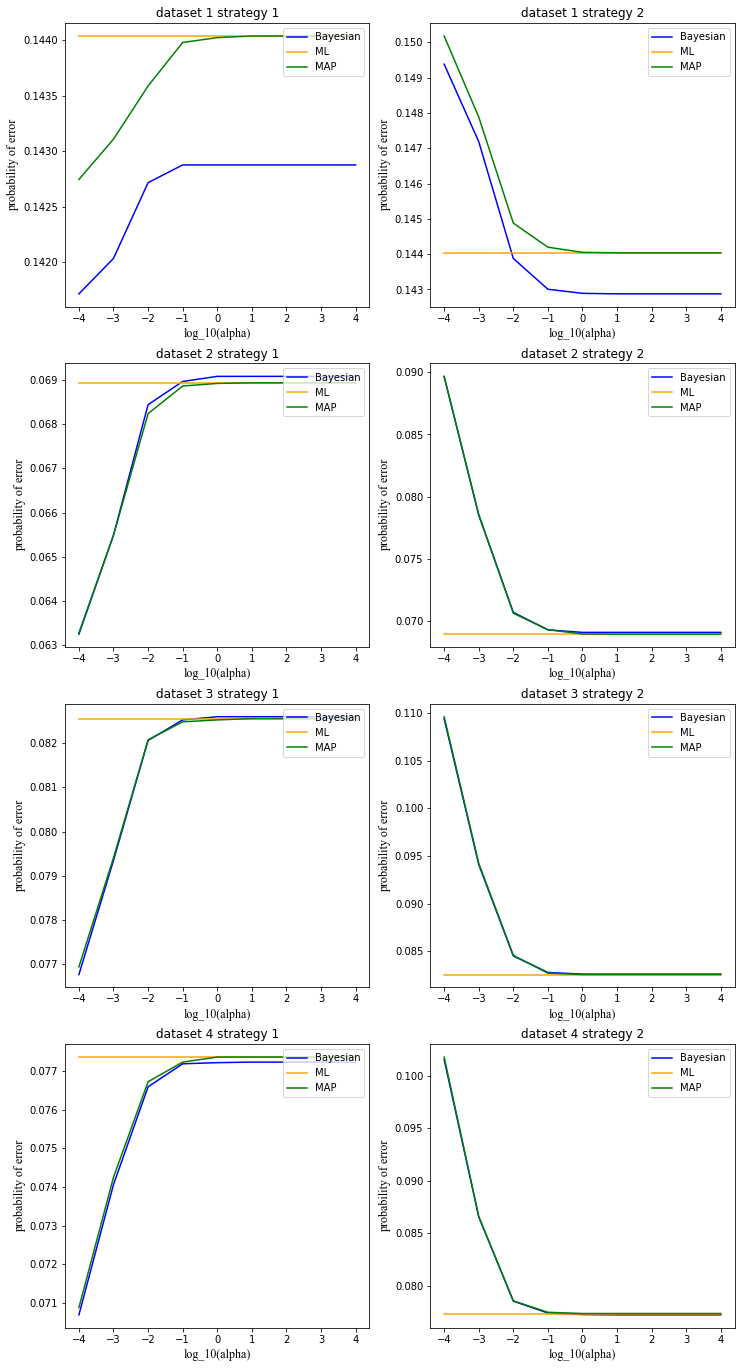

In [22]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,24))
title = ['strategy 1','strategy 2']
for i in range(len(FG)):
    for j in range(2):
        fig.add_subplot(4,2,(2*i+j)+1)
        x = np.log10(a.flatten())
        if j == 0:
            plt.plot(x,error_list_1[i],label = 'Bayesian',color='blue')
            plt.plot(x,error_list_ML[i],label = 'ML',color = 'orange')
            plt.plot(x,error_list_M1[i],label = 'MAP',color = 'green')
            plt.title('dataset %d '%(i+1) + title[j])
        else:
            plt.plot(x,error_list_2[i],label = 'Bayesian',color='blue')
            plt.plot(x,error_list_ML[i],label = 'ML',color = 'orange')
            plt.plot(x,error_list_M2[i],label = 'MAP',color = 'green')
            plt.title('dataset %d '%(i+1) + title[j])
        plt.legend(loc='upper right')
        plt.xlabel('log_10(alpha)', fontdict={'family' : 'Times New Roman', 'size'   : 12})
        plt.ylabel('probability of error', fontdict={'family' : 'Times New Roman', 'size'   : 12})
plt.show()

### d) Explanation of the plottings:

#### 1) Relative behavior of these three curves:

From observation we can see that when $\alpha$ is small, POE calculated by Bayesian BDR and MAP BDR is quite different from the POE calcuated by ML BDR; when $\alpha$ gets larger, the difference between the three gets smaller and Bayesian MAP BDR generally converges to ML BDR when $\alpha$ is incredibly large.
<br/>
<br/>
Given that $\Sigma_{0ii}=\alpha w_i$；   $\mu_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\hat{\mu}+\frac{1}{N}\Sigma(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\mu_0;\quad\Sigma_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\frac{1}{N}\Sigma$

The explanation for the behavior is: When $\alpha$ is really small, the corresoponding $\Sigma_0$ will be small. The posterior mean will be mostly contributed by prior(weight 2 is way larger than weight 1). The posterior covariance $\Sigma_1$ will be small when $\alpha$ is small. This explains why the Bayesian BDR and ML BDR is quite different at the begining. Since Bayesian BDR and MAP BDR shares the same posterior mean, POE calculated by Bayesian BDR and MAP BDR is closer compared to the difference between ML BDR and Bayesian BDR when $\alpha$ is small.
<br/><br/>
When $\alpha$ is really large, the weight of $\hat{\mu}$ gets larger. The posterior mean will gradually converge to ML estimate of the mean. Since MAP BDR and ML BDR shares the same covariance matrix, when $\alpha$ gets really large POE calculated by MAP BDR is almost the same as the result calculated by ML BDR. The posterior covariance matrix will will be closer to the covariance matrix of ML estimate. So when $\alpha$ gets larger, POE calculated by Bayesian BDR will generally get closer to the result of ML estimate.

#### 2) How the behavior of three curves changes from dataset to dataset:

From observation we can see that in dataset 1 and dataset 2, the difference between the three curves is generally larger than the difference between the three curves in dataset 3 and 4 when $\alpha$ is large enough ($log_{10}\alpha \ge 1$).

$\mu_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\hat{\mu}+\frac{1}{N}\Sigma(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\mu_0;\quad\Sigma_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\frac{1}{N}\Sigma$

The difference between the these four dataset is the number of data samples ($N$) within each dataset. When $N$ gets larger, the posterior mean will generally converges to $\hat{\mu}$ - the ML estimate of $\mu$ if $\alpha$ is large enough. The posterior covariance will be closer to $\frac{1}{N}\Sigma$, which will go to zero if N is sufficiently large when $\alpha$ is large enough. This is why in dataset 3 and dataset 4, the POE calculated by Bayesian BDR and ML BDR when $log_{10}\alpha \ge 1$ is closer compared with dataset 1 and dataset 2 under the same condition.

#### 3) how the behavior changes when strategy 1 is replaced by strategy 2:

From oberservation we can see that there are no differences for ML BDR with strategy 1 and strategy 2. Using strategy 1, the POE calculated by Bayesian BDR and MAP BDR increases when $\alpha$ increases while using strategy 2, POE calculated by Bayesian BDR and MAP BDR decreases when $\alpha$ increases.

$\mu_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\hat{\mu}+\frac{1}{N}\Sigma(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\mu_0;\quad\Sigma_1=\Sigma_0(\Sigma_0+\frac{1}{N}\Sigma)^{-1}\frac{1}{N}\Sigma$

The difference between strategy 1 and strategy 2 is the prior mean (the prior covariace is the same). $\mu_{0,1}$ is smaller for the (darker) cheetah class $\mu_{0,1} = 1$ and larger for the (lighter) grass class $\mu_{0,1} = 3$. Compared to strategy 2, which is that $\mu_0$ for both cheetah and grass is exactly the same, strategy 1 makes more sense since the it differentiate the foreground from the background. As mentioned previously, when $\alpha$ is small, the prior mean $\mu_0$ weighs more than $\hat{\mu}$. Thus the quality of the prior $\mu_0$ will greatly influence the POE. Thus piror under strategy 1 makes the result of Bayesian BDR and MAP BDR better than ML BDR when $\alpha$ is small while the prior under strategy 2 makes the result of Bayesian BDR and MAP BDR worse than ML BDR. When $\alpha$ gets larger, POE calculated by MAP BDR and Bayesian BDR will generally be closer. This explains the different trends we observed using strategy 1 and strategy 2.